In [18]:
from tool import *
import torch

In [19]:
env = MyWrapper()
env.reset()

array([ 0.03921332,  0.01333219, -0.03220644,  0.04860539], dtype=float32)

In [20]:
class Model_action(torch.nn.Module):
    def __init__(self):
        super(Model_action, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(4, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 2),
            torch.nn.Softmax(dim=1),
        )
            
    def forward(self, state):
        return self.fc(state)

class Model_baseline(torch.nn.Module):
    def __init__(self):
        super(Model_baseline, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(4, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
        )
        
    def forward(self, state):
        return self.fc(state)

model_action = Model_action()
model_baseline = Model_baseline()

In [21]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []

    s = env.reset()
    o = False
    while not o:
        #根据概率采样
        prob = model_action(torch.FloatTensor(s).reshape(1, 4))[0].tolist()
        a = random.choices(range(2), weights=prob, k=1)[0]

        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state).reshape(-1, 4)
    action = torch.LongTensor(action).reshape(-1, 1)
    reward = torch.FloatTensor(reward).reshape(-1, 1)

    return state, action, reward, reward.sum().item()


state, action, reward, reward_sum = play()

reward_sum

-973.0

In [22]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-3)
optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=5e-4)

In [23]:
state, action, reward, reward_sum = play()

In [24]:
def get_value(reward):
    #计算当前state的价值,其实就是Q(state,action),这里是用蒙特卡洛法估计的
    value = []
    for i in range(len(reward)):
        s = 0
        for j in range(i, len(reward)):
            s += reward[j] * 0.99**(j - i)
        value.append(s)

    return torch.FloatTensor(value).reshape(-1, 1)


value = get_value(reward)

value.shape

torch.Size([25, 1])

In [25]:
#训练baseline模型
def train_baseline(state, value):
    baseline = model_baseline(state)

    loss = torch.nn.functional.mse_loss(baseline, value)
    loss.backward()
    optimizer_baseline.step()
    optimizer_baseline.zero_grad()

    return baseline.detach()


baseline = train_baseline(state, value)

baseline.shape

torch.Size([25, 1])

In [26]:
#训练action模型
def train_action(state, action, value, baseline):
    #重新计算动作的概率
    prob = model_action(state).gather(dim=1, index=action)

    #求Q最大的导函数 -> partial value / partial action
    #注意这里的Q使用前要去基线,这也是baseline模型存在的意义
    prob = (prob + 1e-8).log() * (value - baseline)
    for i in range(len(prob)):
        prob[i] = prob[i] * 0.99**i
    loss = -prob.mean()

    loss.backward()
    optimizer_action.step()
    optimizer_action.zero_grad()

    return loss.item()


train_action(state, action, value, baseline)

-527.9689331054688

In [27]:
#训练
def train():
    model_action.train()
    model_baseline.train()

    #训练N局
    for epoch in range(1000):
        #玩一局游戏,得到数据
        state, action, reward, _ = play()
        #训练两个模型
        value = get_value(reward)
        baseline = train_baseline(state, value)
        loss = train_action(state, action, value, baseline)

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss, test_result)


train()

0 -548.5003662109375 -982.85
100 -471.5755615234375 -964.05
200 -199.2019805908203 -846.85
300 18.61717987060547 92.85
400 18.147506713867188 200.0
500 19.621679306030273 200.0
600 19.137928009033203 200.0
700 17.834165573120117 142.25
800 19.338045120239258 200.0
900 16.320999145507812 200.0


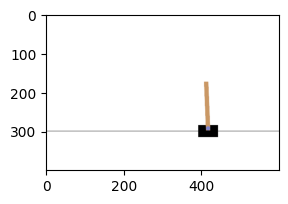

200.0

In [28]:
play(True)[-1]